Electricity Demand Forecasting

## Data Understanding and Preparation

The electricity demand forecasting model was trained on a continuous dataset containing hourly data collected from multiple sources. This dataset includes weather measurements from three locations in Panama (Tocumen, San Miguelito, and David) and national electricity demand data. Key features include temperature at 2 meters (T2M), humidity (QV2M), wind speed (W2M), and total column liquid water (TQL), along with calendar variables such as holidays and school schedules. To improve performance, I also added lag features (e.g., demand 1, 2, and 24 hours ago) and cyclical time features using sine and cosine transformations to capture the time of day. All features were normalized using MinMax scaling before training the model.

## 1. Base GRU Model

The base GRU model is the starting point for predicting electricity demand. It looks at 24 hours of past data using 15 features like temperature, humidity, and holiday indicators. It tries to predict the demand for the next hour (t+1).

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# Load data
df = pd.read_csv('continuous dataset.csv', parse_dates=['datetime'])

# Select features and target
features = [
    'T2M_toc','QV2M_toc','TQL_toc','W2M_toc',
    'T2M_san','QV2M_san','TQL_san','W2M_san',
    'T2M_dav','QV2M_dav','TQL_dav','W2M_dav',
    'Holiday_ID','holiday','school'
]
target = 'nat_demand'

# Scale features and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Create sequences for time series
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:(i+seq_length)])
        ys.append(y[i+seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24       # For 24 Hours
X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


It uses 4 GRU layers, each with 256 units, and ends with a simple output layer. The model was trained to reduce the difference between predicted and real demand.

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Model Architecture
INPUT_SIZE = len(features)
HIDDEN_SIZE = 256
NUM_LAYERS = 4
OUTPUT_SIZE = 1
DROPOUT = 0.4

model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout=DROPOUT)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        # Learning Rate (lr)

EPOCHS = 50       # Number of Epochs

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}')


Epoch 10/50, Loss: 0.0037
Epoch 20/50, Loss: 0.0022
Epoch 30/50, Loss: 0.0006
Epoch 40/50, Loss: 0.0004
Epoch 50/50, Loss: 0.0003


In [ ]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        predictions.append(output.cpu().numpy())
        actuals.append(y_batch.numpy())
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform to original scale
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)
print(f'Test MSE: {mse:.2f}')

from sklearn.metrics import mean_absolute_percentage_error

mape_gru = mean_absolute_percentage_error(actuals, predictions)
accuracy_gru = 100 * (1 - mape_gru)
print(f"GRU Model Accuracy (t+1): {accuracy_gru:.2f}%")


Test MSE: 23815.35
GRU Model Accuracy (t+1): 90.33%


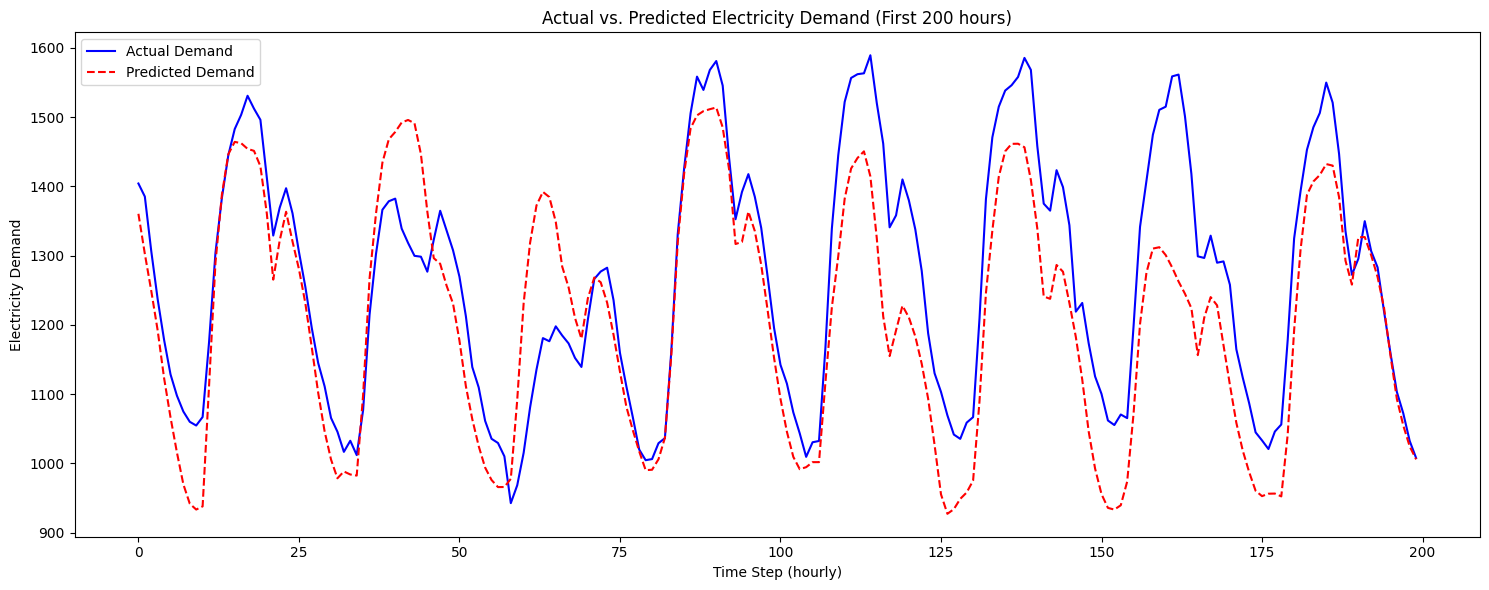

In [ ]:
# Plotting the first 200 test samples for clarity (adjust as needed)
plt.figure(figsize=(15, 6))
plt.plot(actuals[:200], label='Actual Demand', color='blue')
plt.plot(predictions[:200], label='Predicted Demand', color='red', linestyle='--')
plt.title('Actual vs. Predicted Electricity Demand (First 200 hours)')
plt.xlabel('Time Step (hourly)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.tight_layout()
plt.show()


While the model can follow general trends, it has trouble with sudden spikes. It ended with a test MSE of 23,815.06 and 90.33% accuracy.

## 2. GRU + Attention Model

The improved model uses the same GRU structure but adds an attention layer. This helps the model focus on the most important parts of the past data when making predictions.

In [ ]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Loading the data
df = pd.read_csv('/content/sample_data/continuous dataset.csv', parse_dates=['datetime'])

In [ ]:
# Add lag & time features
df['lag1'] = df['nat_demand'].shift(1)
df['lag2'] = df['nat_demand'].shift(2)
df['lag24'] = df['nat_demand'].shift(24)
df['hour'] = df['datetime'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df = df.dropna().reset_index(drop=True)

# Features
features = [
    'T2M_toc','QV2M_toc','TQL_toc','W2M_toc',
    'T2M_san','QV2M_san','TQL_san','W2M_san',
    'T2M_dav','QV2M_dav','TQL_dav','W2M_dav',
    'Holiday_ID','holiday','school',
    'lag1', 'lag2', 'lag24', 'hour_sin', 'hour_cos'
]
target = 'nat_demand'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

It looks at 48 hours of past data and uses 20 features. These include extra inputs like lagged demand and time-of-day information. It predicts demand for the next 6 hours (t+1 to t+6).

In [ ]:
# Creating the Sequence for Input
def create_multi_sequences(X, y, seq_length=48, forecast_horizon=12):
    xs, ys = [], []
    for i in range(len(X) - seq_length - forecast_horizon):
        xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length:i+seq_length+forecast_horizon].flatten())
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 48         # Fine-tune the sequence length for optimization
FORECAST_HORIZON = 6  # Change to 6 or 24 if desired
X_seq, y_seq = create_multi_sequences(X_scaled, y_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [ ]:
# Converting the dataset into dataloder
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

It has 2 GRU layers with 128 units each, and the attention layer gives weight to more important time steps. The model is better at predicting short-term changes.

In [ ]:
# Model Definition
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = self.attn(x).squeeze(-1)
        attn_weights = torch.softmax(weights, dim=1)
        context = torch.sum(x * attn_weights.unsqueeze(-1), dim=1)
        return context

class GRUWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUWithAttention, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        context = self.attention(out)
        return self.fc(context)

model = GRUWithAttention(input_size=len(features), hidden_size=128, num_layers=2, output_size=FORECAST_HORIZON)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GRUWithAttention(
  (gru): GRU(20, 128, num_layers=2, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10           # Number of Iterations
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}")

Epoch 1/10 - Train Loss: 0.0096
Epoch 2/10 - Train Loss: 0.0033
Epoch 3/10 - Train Loss: 0.0026
Epoch 4/10 - Train Loss: 0.0019
Epoch 5/10 - Train Loss: 0.0013
Epoch 6/10 - Train Loss: 0.0011
Epoch 7/10 - Train Loss: 0.0009
Epoch 8/10 - Train Loss: 0.0009
Epoch 9/10 - Train Loss: 0.0008
Epoch 10/10 - Train Loss: 0.0008


In [ ]:
# Model Evaluation
import numpy as np
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().detach().numpy())
        actuals.append(y_batch.numpy())

y_pred = np.concatenate(predictions)
y_true = np.concatenate(actuals)

y_pred_actual = scaler_y.inverse_transform(y_pred)
y_true_actual = scaler_y.inverse_transform(y_true)

mse_t1 = mean_squared_error(y_true_actual[:, 0], y_pred_actual[:, 0])

# Calculating Test MSE
mse_t12 = mean_squared_error(y_true_actual[:, -1], y_pred_actual[:, -1])

print(f"Test MSE for t+1: {mse_t1:.2f}")
print(f"Test MSE for t+12: {mse_t12:.2f}")

Test MSE for t+1: 2887.58
Test MSE for t+12: 9900.89


In [ ]:
# t+1 accuracy
mape_t1 = mean_absolute_percentage_error(y_true_actual[:, 0], y_pred_actual[:, 0])
accuracy_t1 = 100 * (1 - mape_t1)

# t+6 accuracy
mape_t12 = mean_absolute_percentage_error(y_true_actual[:, -1], y_pred_actual[:, -1])
accuracy_t12 = 100 * (1 - mape_t12)

print(f"Model Accuracy for t+1: {accuracy_t1:.2f}%")
print(f"Model Accuracy for t+6: {accuracy_t12:.2f}%")

Model Accuracy for t+1: 96.83%
Model Accuracy for t+6: 94.63%


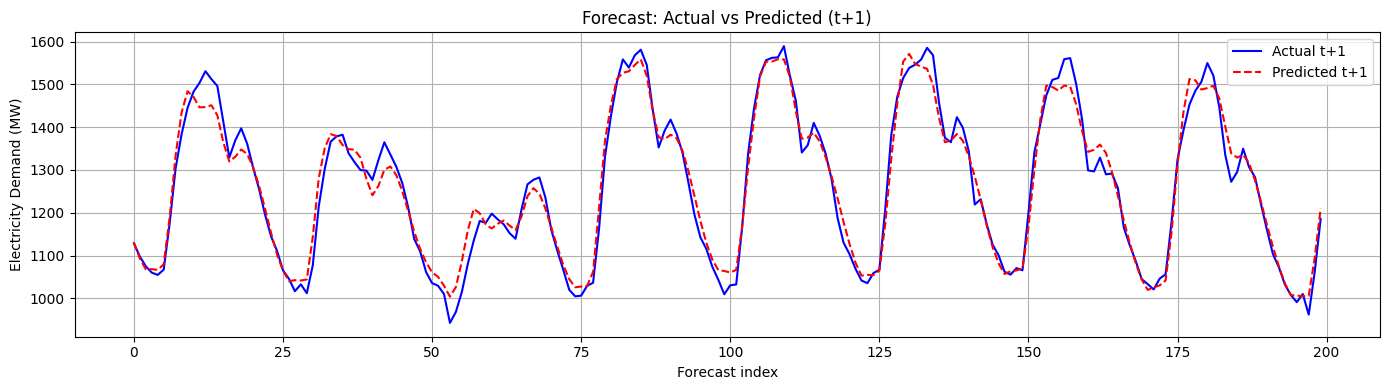

In [ ]:
# Chart 1: Actual vs Predicted for t+1
plt.figure(figsize=(14, 4))
plt.plot(y_true_actual[:200, 0], label="Actual t+1", color="blue")
plt.plot(y_pred_actual[:200, 0], label="Predicted t+1", color="red", linestyle="--")
plt.title("Forecast: Actual vs Predicted (t+1)")
plt.xlabel("Forecast index")
plt.ylabel("Electricity Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

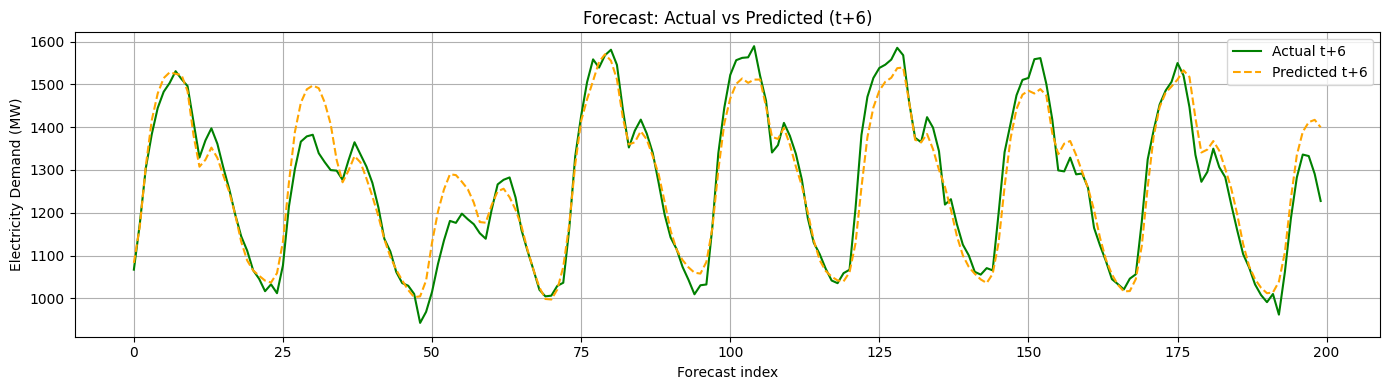

In [ ]:
# Chart 2: Actual vs Predicted for t+6
plt.figure(figsize=(14, 4))
plt.plot(y_true_actual[:200, -1], label="Actual t+6", color="green")
plt.plot(y_pred_actual[:200, -1], label="Predicted t+6", color="orange", linestyle="--")
plt.title("Forecast: Actual vs Predicted (t+6)")
plt.xlabel("Forecast index")
plt.ylabel("Electricity Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This shows the model works well for both short-term and medium-range forecasting.